# k-Nearest Neighbors

So we have spent a fair amount of time now with our first two models. Both models are fundamentally linear. 

*Linear Regression* is looking for the linear combination of the factors that best produces the result, maximizing the coefficient of prediction $R^2$. 

*Logistic Regression* (which again is classification) is looking for a linear expression in the logistic model that best produces a decision boundary explaining the data. Because the base function is linear this produces decision boundaries that are also linear. The decision boundary also cannot be too complicated, for one feature the decision can only be at one point, for two features the decsion can only be on one line segment.

Each of these models can be generalized to nonlinear ones by introducing new features that are transformations of the existing features.

Today we will talk about our first fundamentally non-linear model. These models will introduce additional degrees of freedom that result in models capable of adapting to the training data very closely. Which means then that overfitting becomes much more likely. What we will see is that there is a definite trade off between the complexity or freedom given to our model and the possibility of overfitting.

The k-Nearest Neighbors model will start as a classification model and then we will come back later and adapt it to a regression problem. This will also be the model that I will ask you and your team to write an algorithm for as part of class. Today we will use the existing tool in scikitlearn.

We'll start with the Kidney Disease dataset.

In [1]:
import pandas as pa
import matplotlib.pyplot as plt
import matplotlib.colors as pltco # A package to help with coloring plots
import seaborn as sn
import numpy as np
import numpy.random as rn

In [2]:
kd = pa.read_csv('Data Sets/Kidney/chronic_kidney_disease.csv', 
                 names=['age', 'bp', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                        'pus_cell_clumps', 'bacteria', 'blood_glucose', 'blood_urea', 'serum_creatinine', 
                        'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
                        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
                        'appetite', 'pedal_edema', 'anemia', 'class'])

kd.loc[kd.loc[:, 'class'] == 'ckd\t', 'class'] = 'ckd'  # There is an extra tab character on some of the ckd values

kd.head()

,age,bp,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
# There are some missing values for hemoglobin and blood pressure

kd = kd[kd.hemoglobin != '?']
kd = kd[kd.bp != '?']

In [4]:
# Many of the numerical values were read as strings so we have to convert the ones we want to use

# Which by the way produces an error in Seaborn.pairplot

for k in kd.index:
    kd.loc[k, 'hemoglobin'] = float(kd.loc[k, 'hemoglobin'])
    kd.loc[k, 'bp'] = int(kd.loc[k, 'bp'])

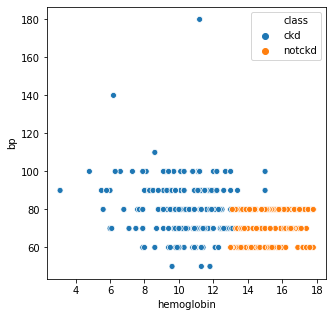

In [6]:
plt.figure(figsize=(5, 5))
sn.scatterplot(x='hemoglobin', y='bp', hue='class', data=kd);

plt.savefig('11.1.png')

The idea for the model is to use the nearby training data to determine what class a point in this coordinate system should be classified as. I.e. given a (hemoglobin, age) pair, we use the $k$-nearest points to that pair to determine the classification at the point. How do they decide, well we let them vote and majority determines the value. Ties will happen, but only along small dimensional subsets so they do not effectively matter.

The smaller $k$ is the more our model will adapt to the training data. When $k=1$ the model uses the classification of the closest point from the training data.

In [7]:
# Set our numpy array from the dataframe

X = np.array(kd[['hemoglobin', 'bp']])
kd['class'] = kd['class'].map({'ckd':1, 'notckd':0, 1:1, 0:0})  # Recode the result feature to be numeric; 
# note the second two values in the dictionary are in case we run this block again

y = np.array(kd[['class']]).reshape(-1)  # had to reshape it to be a vector and not a matrix

In [8]:
# Make the training and testing sets

n = X.shape[0]
test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
perm = rn.permutation(n)   
X = X[perm]
y = y[perm]
X_test = X[:test]       # Then create the test
y_test = y[:test]
X_train = X[test:]     # and train sets
y_train = y[test:]

In [9]:
# Load the classifier from scikitlearn

from sklearn.neighbors import KNeighborsClassifier

In [10]:
clf1 = KNeighborsClassifier(n_neighbors=1) # Define the model
clf1.fit(X_train, y_train); # Train the model

In [11]:
# A bit of code for plotting the decision boundaries in a categorical problem with two predictors and two values for the result
# Also prints out the training and testing errors

def plot_cat_model(clf, X_train, y_train, X_test, y_test):

    h = 0.1 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, 185
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

Training Error: 0.9704797047970479
Testing Error: 0.9253731343283582


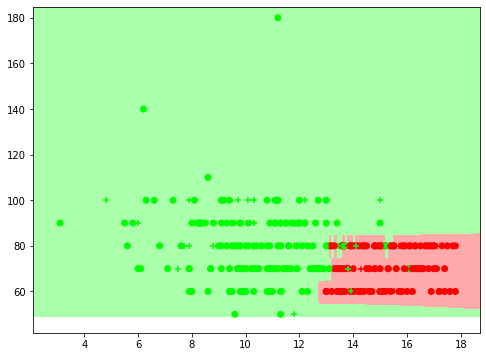

In [12]:
plot_cat_model(clf1, X_train, y_train, X_test, y_test)
plt.savefig('11.2.png')

Note the evidence of overfitting: rapid changes in the boundary and islands. As we increase $k$ the model becomes more rigid and therefore less prone to overfitting. 

Training Error: 0.959409594095941
Testing Error: 0.9104477611940298


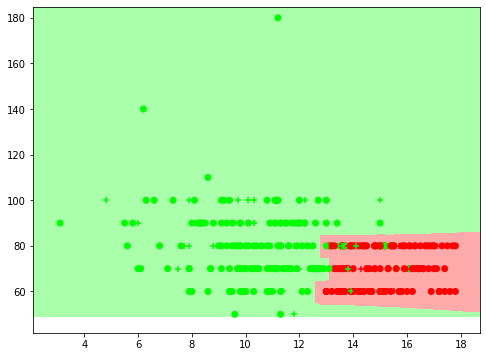

In [13]:
clf2 = KNeighborsClassifier(n_neighbors=2) # Define the model
clf2.fit(X_train, y_train)
plot_cat_model(clf2, X_train, y_train, X_test, y_test)
plt.savefig('11.3.png')

Training Error: 0.959409594095941
Testing Error: 0.9253731343283582


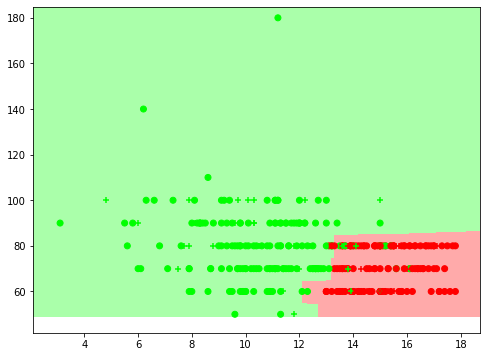

In [14]:
clf3 = KNeighborsClassifier(n_neighbors=7) # Define the model
clf3.fit(X_train, y_train)
plot_cat_model(clf3, X_train, y_train, X_test, y_test)
plt.savefig('11.4.png')

Note that it does give a model that seems to have some features missed by the Logistic Regression model.

Training Error: 0.9520295202952029
Testing Error: 0.9253731343283582


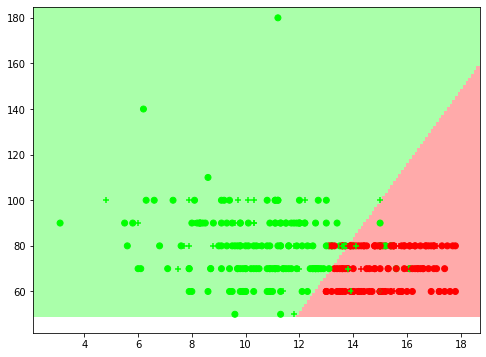

In [15]:
# Compared to a logistic model on the same data
from sklearn.linear_model import LogisticRegression
lgm = LogisticRegression(solver='lbfgs', multi_class='auto').fit(X_train, y_train)
plot_cat_model(lgm, X_train, y_train, X_test, y_test)
plt.savefig('11.5.png')